In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\28057\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:

reddit_data = pd.read_csv('merged_data.csv')
reddit_data_cleaned = reddit_data.dropna(subset=['Comment Body'])



nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

reddit_data_cleaned['Comment Body'] = reddit_data_cleaned['Comment Body'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\28057\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Modeling

# Check for Model

In [6]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = vectorizer.fit_transform(reddit_data_cleaned['Comment Body'])

lda = LatentDirichletAllocation(n_components=10, random_state=0)
lda.fit(tfidf)

n_topics = [5, 10, 15, 20, 25]
best_lda_model = None
best_score = float('-inf')

for n in n_topics:
    lda_model = LatentDirichletAllocation(n_components=n, max_iter=10, random_state=42)
    lda_model.fit(tfidf)
    silhouette_avg = silhouette_score(tfidf, lda_model.transform(tfidf).argmax(axis=1))
    print(f"For n_topics = {n}, silhouette score is {silhouette_avg}")
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_lda_model = lda_model

print("\nBest LDA model parameters:")
print(best_lda_model.get_params())


For n_topics = 5, silhouette score is -0.01846485725800859
For n_topics = 10, silhouette score is -0.04048180206133598
For n_topics = 15, silhouette score is -0.056403714562052475
For n_topics = 20, silhouette score is -0.06371372845922019
For n_topics = 25, silhouette score is -0.06661219096585147

Best LDA model parameters:
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 5, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation


vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = vectorizer.fit_transform(reddit_data_cleaned['Comment Body'])


best_params = {
    'batch_size': 128,
    'doc_topic_prior': None,
    'evaluate_every': -1,
    'learning_decay': 0.7,
    'learning_method': 'batch',
    'learning_offset': 10.0,
    'max_doc_update_iter': 100,
    'max_iter': 10,
    'mean_change_tol': 0.001,
    'n_components': 5,
    'n_jobs': None,
    'perp_tol': 0.1,
    'random_state': 42,
    'topic_word_prior': None,
    'total_samples': 1000000.0,
    'verbose': 0
}

lda = LatentDirichletAllocation(**best_params)
lda_results = lda.fit_transform(tfidf)


reddit_data_cleaned['main_topic'] = lda_results.argmax(axis=1)

def get_top_words(model, feature_names, n_top_words=10):
    """Get top words for each topic."""
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(top_words)
    return topics

feature_names = vectorizer.get_feature_names_out()
top_words_per_topic = get_top_words(lda, feature_names, 10)

for idx, topic in enumerate(top_words_per_topic):
    print(f"Topic {idx+1}: {' , '.join(topic)}")


Topic 1: thank , elon , wow , nice , cool , jeff , oh , realli , funni , american
Topic 2: http , com , elon , love , twitter , comment , reddit , good , post , say
Topic 3: peopl , like , tesla , make , car , money , elon , work , think , compani
Topic 4: right , elon , pleas , awesom , happi , like , true , birthday , way , amaz
Topic 5: elon , like , fuck , lol , musk , look , na , gon , shit , know


In [8]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel


texts = reddit_data_cleaned['Comment Body'].str.split().tolist()
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


lda_gensim = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10)


coherence_model_lda = CoherenceModel(model=lda_gensim, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('Coherence Score: ', coherence_lda)



Coherence Score:  0.5802397165029257


# Analysis of the title

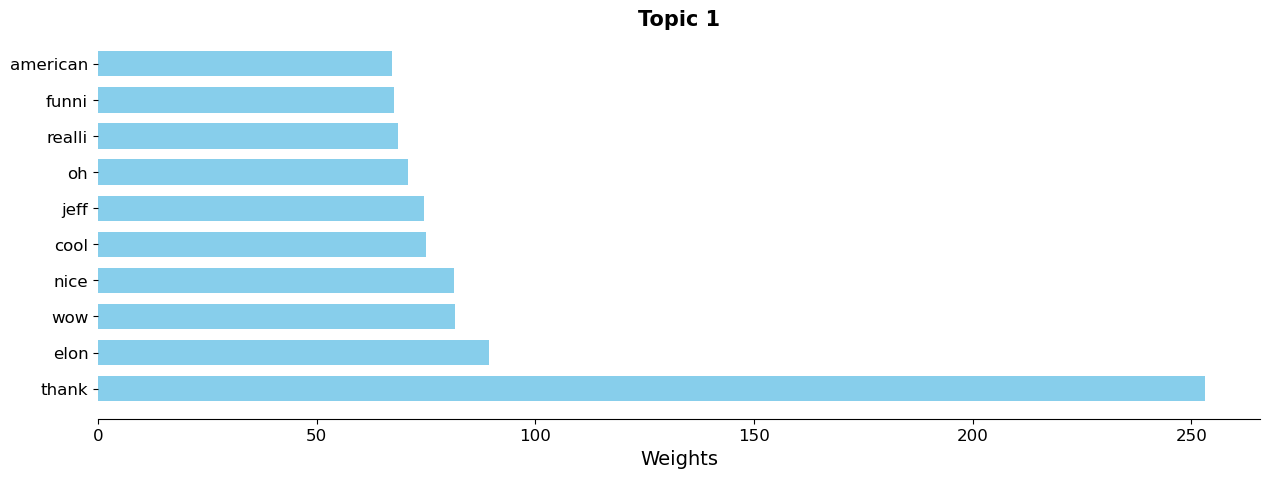

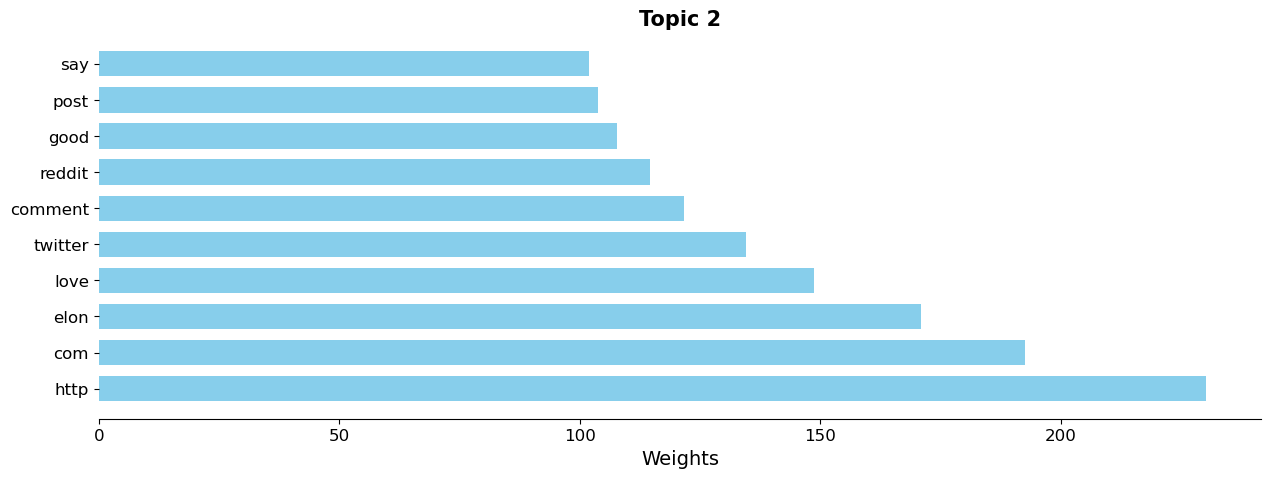

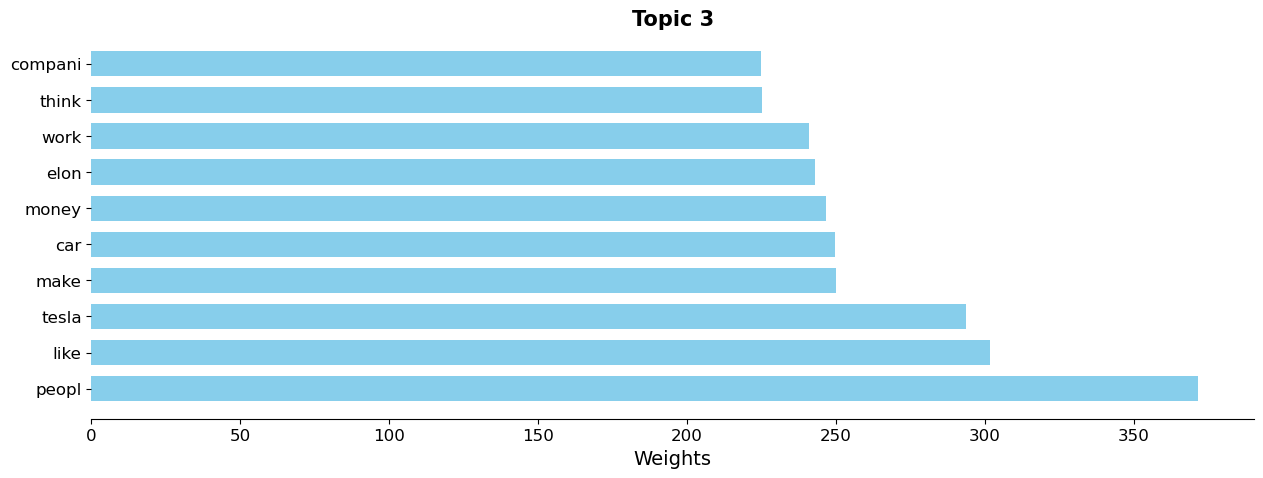

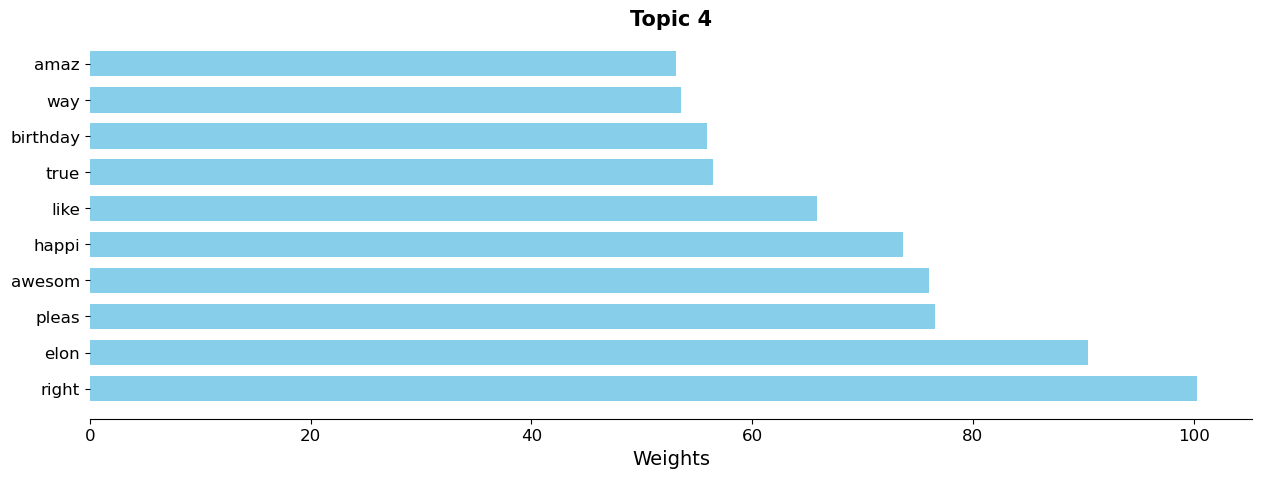

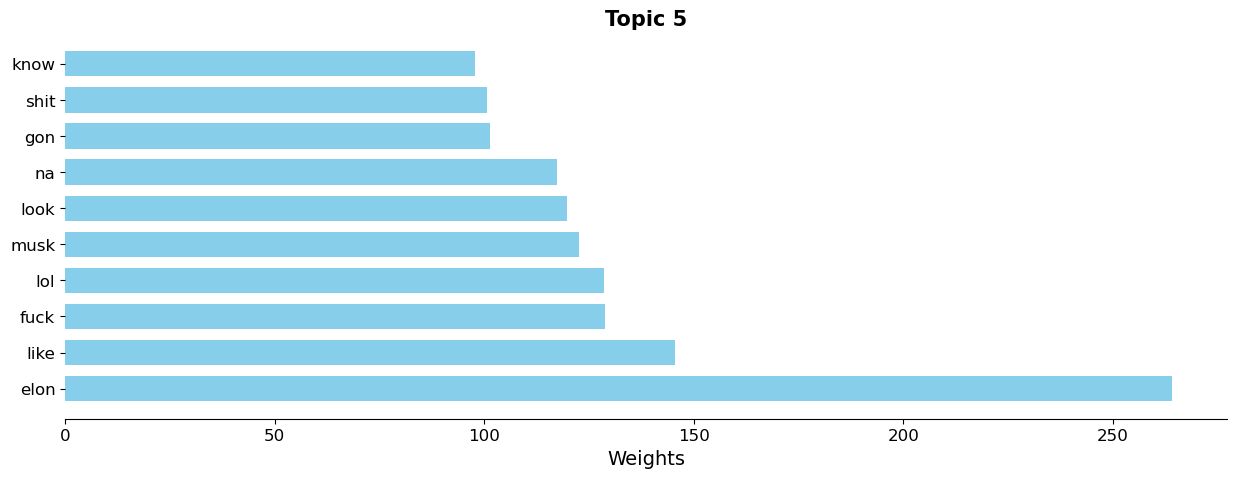

In [4]:
import matplotlib.pyplot as plt

def plot_top_words_sorted(lda_model, vectorizer, n_words=10):
    terms = vectorizer.get_feature_names_out()
    
    for topic_idx, topic in enumerate(lda_model.components_):
        top_features_ind = topic.argsort()[-n_words:][::-1]
        top_features = [terms[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        
        # Sorting the bars according to their weights
        sorted_idx = weights.argsort()
        top_features = [top_features[i] for i in sorted_idx]
        weights = [weights[i] for i in sorted_idx]

        plt.figure(figsize=(15, 5))
        plt.barh(top_features, weights, height=0.7, color='skyblue')
        plt.xlabel('Weights', fontsize=14)
        plt.title(f'Topic {topic_idx + 1}', fontweight='bold', fontsize=15)
        plt.gca().invert_yaxis()  # To display the top keyword at the top
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        
        for i in 'top right left'.split():
            plt.gca().spines[i].set_visible(False)
        
        plt.show()

plot_top_words_sorted(lda, vectorizer)


1,Topic 1: General Appreciation and Surprise

Keywords: thank, elon, wow, nice, cool, jeff, oh, really, funny, american

Analysis: This topic appears to revolve around general appreciation and elements of surprise. Words like "thank," "wow," "nice," and "cool" suggest positive reactions, possibly to some updates, achievements, or announcements. The word "jeff" could be a reference to Jeff Bezos, hinting at discussions comparing him with Elon Musk. The term "american" might indicate discussions about Elon Musk's impact or status in the U.S.

2,Topic 2: Online Conversations and References

Keywords: http, com, elon, love, twitter, comment, reddit, good, post, say

Analysis: This topic seems to be about online references and discussions concerning Elon Musk. Terms like "http," "com," "twitter," and "reddit" indicate web references or links. The presence of words like "comment" and "post" suggests active online conversations about Musk.

3,Topic 3: Business, Ventures, and Public Perception

Keywords: people, like, tesla, make, car, money, elon, work, think, company

Analysis: This topic appears to center around Elon Musk's businesses, especially Tesla, and the public's perception of them. Words like "tesla," "car," "money," and "company" indicate business discussions, while "people," "like," and "think" hint at the general public's opinions or perceptions.

4,Topic 4: Positive Sentiments and Celebratory Remarks

Keywords: right, elon, please, awesome, happy, like, true, birthday, way, amazing

Analysis: This topic reflects positivity and possibly celebratory discussions related to Elon Musk. "Awesome," "happy," and "amazing" are positive sentiments. "Birthday" could indicate discussions or celebrations related to Elon Musk's birthday or significant milestones.

5,Topic 5: Mixed Emotions and Slang Expressions

Keywords: elon, like, fuck, lol, musk, look, na, gon, shit, know

Analysis: This topic seems to showcase mixed emotions and slang expressions in discussions about Elon Musk. Words like "fuck," "lol," "shit" indicate strong feelings, both positive and negative. The presence of slang terms like "na" and "gon" (likely short for "going to") suggest a more informal, candid conversation tone.

# Further analysis：sentiment analysis

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chiuy\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


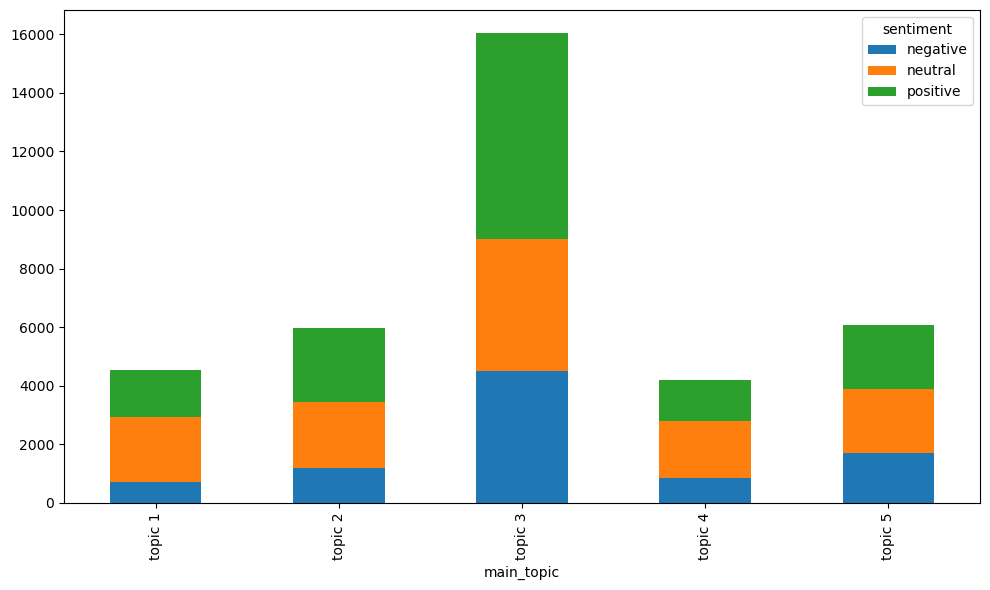

In [4]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

sia = SentimentIntensityAnalyzer()

reddit_data_cleaned['compound'] = reddit_data_cleaned['Comment Body'].apply(lambda x: sia.polarity_scores(x)['compound'])

reddit_data_cleaned['sentiment'] = reddit_data_cleaned['compound'].apply(lambda c: 'positive' if c > 0.05 else ('negative' if c < -0.05 else 'neutral'))

sentiment_distribution = reddit_data_cleaned.groupby(['main_topic', 'sentiment']).size().reset_index(name='counts')

sentiment_distribution = sentiment_distribution.drop_duplicates(subset=['main_topic', 'sentiment'])

sentiment_distribution_pivot = sentiment_distribution.pivot_table(index='main_topic', columns='sentiment', values='counts', aggfunc='sum').fillna(0)

ax = sentiment_distribution_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))

ax.set_xticklabels(['topic ' + str(i) for i in range(1, len(sentiment_distribution_pivot.index)+1)])

plt.tight_layout()
plt.show()




In [5]:
sentiment_proportions = sentiment_distribution_pivot.divide(sentiment_distribution_pivot.sum(axis=1), axis=0)

sentiment_percentages = sentiment_proportions * 100

print(sentiment_percentages)


sentiment    negative    neutral   positive
main_topic                                 
0           15.752368  48.534920  35.712712
1           19.939628  37.866846  42.193527
2           28.090098  28.096337  43.813565
3           19.914550  46.261571  33.823878
4           27.874507  35.939553  36.185940


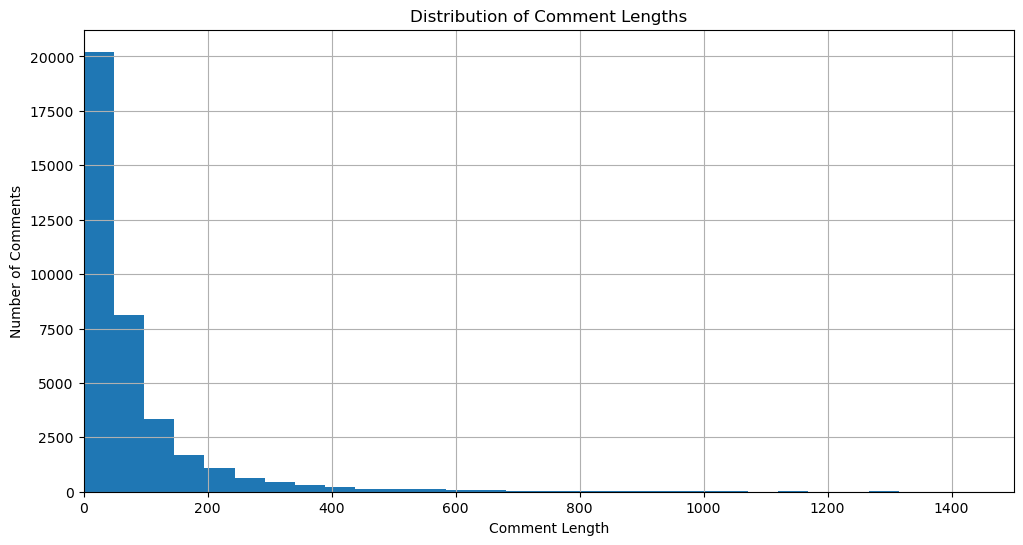

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

reddit_data_cleaned['comment_length'] = reddit_data_cleaned['Comment Body'].apply(len)

plt.figure(figsize=(12, 6))
reddit_data_cleaned['comment_length'].hist(bins=100)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('Number of Comments')


plt.xlim(0, 1500)

plt.show()




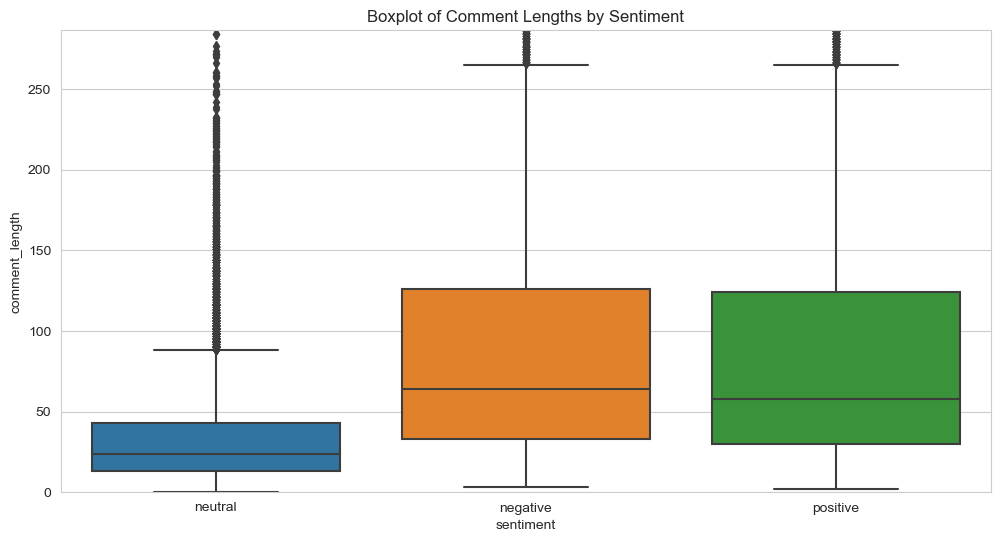

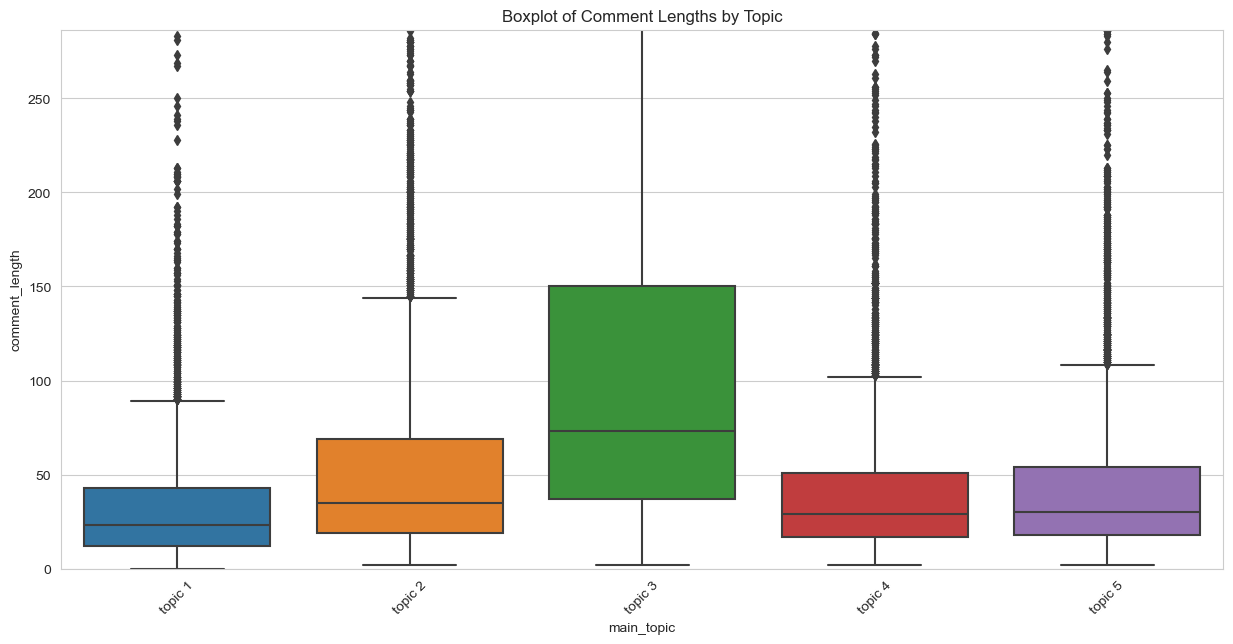

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.boxplot(data=reddit_data_cleaned, x='sentiment', y='comment_length')
plt.title('Boxplot of Comment Lengths by Sentiment')
plt.ylim(0, reddit_data_cleaned['comment_length'].quantile(0.95))  
plt.show()

plt.figure(figsize=(15, 7))
sns.boxplot(data=reddit_data_cleaned, x='main_topic', y='comment_length')
plt.title('Boxplot of Comment Lengths by Topic')
plt.ylim(0, reddit_data_cleaned['comment_length'].quantile(0.95))  

plt.xticks(ticks=range(len(reddit_data_cleaned['main_topic'].unique())), labels=['topic ' + str(i) for i in range(1, len(reddit_data_cleaned['main_topic'].unique())+1)], rotation=45)

plt.show()

